<a href="https://colab.research.google.com/github/kolikaran1992/Neural-Networks/blob/main/Positional_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

SEED = 49

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams.update({'axes.titlesize': 20,
                     'axes.labelsize': 15,
                     'xtick.labelsize':10,
                     'ytick.labelsize':10
                     })

# SIMPLE ENCODING

For an input sequence $[a_0, a_1, ..., a_{n-1}]$ the corresponding positional encoding would be $[0,1,...,n-1]$

**CONS**
1. The scale of numbers can quickly get out of hands (consider a sequence of length 500), it would then lead to nuemrical unstability while training deep networks and lead to problems like vanishing gradients

# NORMALISED COUNT ENCODING

Since we know the length of the sequence before hand, we can normalize the above positional encoding such that the scale does not go out of hands, for an input sequence $[a_0, a_1, ..., a_{n-1}]$ the corresponding positional encoding would be $[\frac{0}{n-1},\frac{1}{n-1},...,\frac{n-1}{n-1}]$

**CONS**
1. Consider a float 0.5, it would correspond to position
    1. 2 ($\frac{2}{4}=0.5$) for a sequence of length 5
    2. 4 ($\frac{4}{8}=0.5$) for a sequence of length 9

# BINARY ENCODING

A decimal number can be represented as a vector of binary numbers. The dimensionality of the positional encoding can be chosen as $log_{2}{l}$, where $l$ is the length of the sequence. For each position, the positional encoding will be the binary number represented as a vector. An example of positional encoding for sequence of length 4

$$\begin{bmatrix}0 & 0 & 1 & 1 \\ 0 & 1 & 0 & 1\end{bmatrix}$$

**CONS**
1. Discontinuity
2. Cannot attend by relative positions, since encondings are not linear transformations of one another

# SINUSOIDAL ENCODINGS

In the above encodings, every bit's value has a cycle associated with it, we can perhaps emulate those cycles by using sin function

$$M_{ij} = sin(\frac{j\pi}{2^i})$$

In [2]:
dim = 3 # dimension of the positional encoding
l = 2**dim # max sequence length

In [3]:
def decimalToBinary(n, total_bits=10):
    bin_lis = list(map(int, bin(n).replace("0b", "")))
    diff = total_bits - len(bin_lis)
    diff = diff if diff > 0 else 0
    rem_arr = [0]*diff
    return rem_arr + bin_lis

def get_binary_enc(dim: int, max_len: int) -> np.array:
    bin_enc = np.array([list(reversed(decimalToBinary(i, dim))) for i in reversed(range(max_len))])
    return bin_enc

In [4]:
def get_sinusoidal_enc(dim: int, max_len: int, period: float = np.pi) -> np.array:
    enc = np.sin(np.array(list(range(1, max_len+1))).reshape(1,-1)*period/np.power(2, np.array(list(range(1, dim+1)))).reshape(-1,1)).T
    return enc

In [5]:
bin_enc = get_binary_enc(dim, l)
bin_enc.shape

(8, 3)

In [6]:
enc = get_sinusoidal_enc(dim, l)
enc.shape

(8, 3)

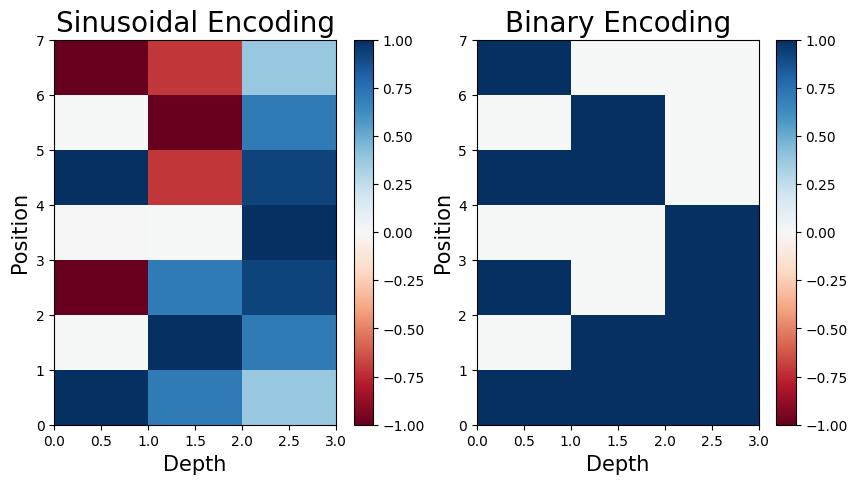

In [7]:
# least significant bit is on the left
fig, axes = plt.subplots(1,2,figsize=(5*2,5))

axes[0].set_title('Sinusoidal Encoding')
im1 = axes[0].pcolormesh(enc, cmap='RdBu')
axes[0].set_xlabel('Depth')
axes[0].set_ylim((0, l-1))
axes[0].set_ylabel('Position')

axes[1].set_title('Binary Encoding')
im2 = axes[1].pcolormesh(bin_enc, cmap='RdBu')
axes[1].set_xlabel('Depth')
axes[1].set_ylim((0, l-1))
axes[1].set_ylabel('Position')

cb1 = fig.colorbar(im1, ax=axes[0])
cb2 = fig.colorbar(im2, ax=axes[1])

# cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)

cb2.mappable.set_clim(*cb1.mappable.get_clim())

plt.show()

On comparing a single column (a specific depth), it can be observed that the sinusoidal encoding (left) is a smoother version of the binary encoding (right)

**NOTE**

The numbers shown in the binary encoding above (right) should be read from right to left instead of left to right, this is done to make similar encoding as shown in the literature for transformers

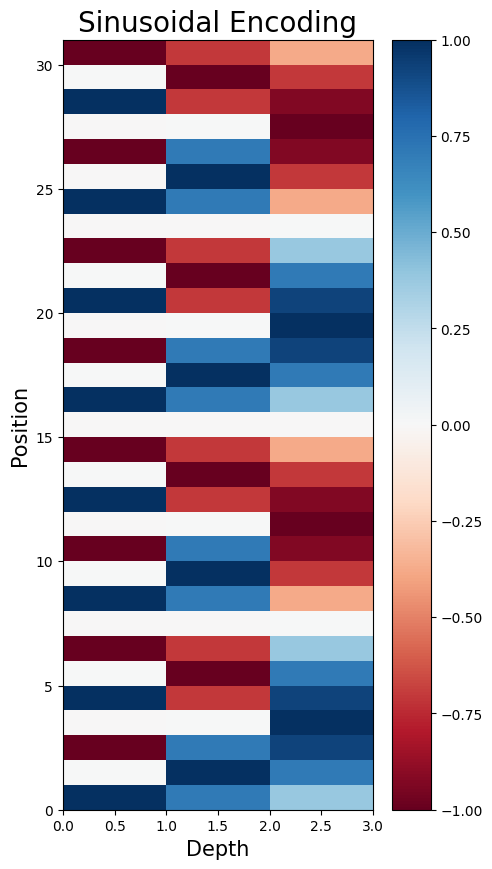

In [8]:
enc = get_sinusoidal_enc(dim, 4*l)

plt.figure(figsize=(5,10))
plt.title('Sinusoidal Encoding')
plt.pcolormesh(enc, cmap='RdBu')
plt.xlabel('Depth')
plt.ylim((0, 4*l-1))
plt.ylabel('Position')
plt.colorbar()

plt.show()

The embeddings start repeating after $2^{dim+1}$ sequence length, this problem can be avoided if we choose a small enough period instead of $\frac{\pi}{2}$. This is possible because we are essentially sampling the embedding using very small periods instead of larger ones while keeping the meaning of sequence preserved

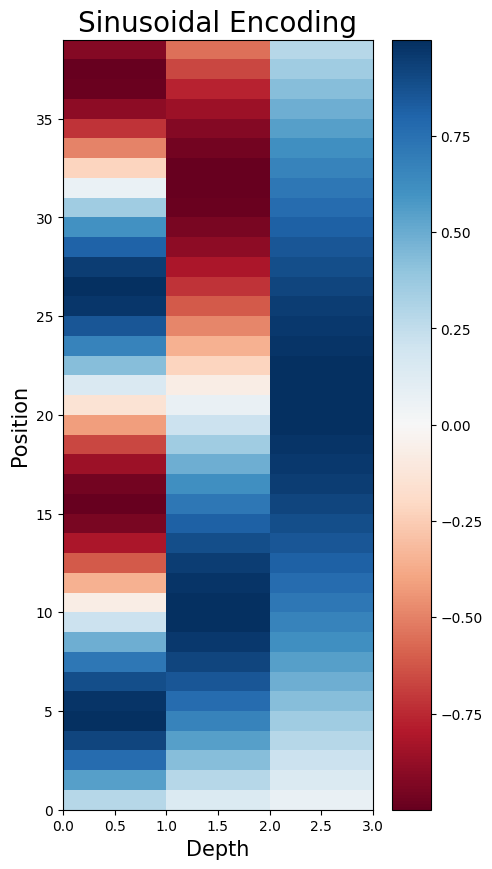

In [9]:
enc = get_sinusoidal_enc(dim, 5*l, period=1/(5**(1/dim)))

plt.figure(figsize=(5,10))
plt.title('Sinusoidal Encoding')
plt.pcolormesh(enc, cmap='RdBu')
plt.xlabel('Depth')
plt.ylim((0, 5*l-1))
plt.ylabel('Position')
plt.colorbar()

plt.show()

**CONS**

There are many common structures in grammar, for example, "subject + verb + object", therefore while translating **verb**, **subject** and **object** will be required. It would be beneficial for a translation model to attend to subject/object which are a few positional indicies away from verb while translating verb. Since the attnetion layer in a transformer model works on linear transformations, it would then be in the model's favor if we could attend to subject/object only using the positional index of the verb

The above property is lacking in the sinusoidal encodings

# POSITIONAL ENCODINGS

$$PE(p, 2i) = sin(\frac{p}{10000^{\frac{2i}{d}}})$$

$$PE(p, 2i+1) = cos(\frac{p}{10000^{\frac{2i}{d}}})$$

Where $d$ is the dimension of the input vectors

In [10]:
def get_angles(pos, i, d):
    """
    pos.shape == (max_pos_enc,1)
    i.shape = (1, d)
    d is an int
    """
    ## (i//2) == array like [[0,0, 1,1, ..., n,n]]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d))
    ## (max_pos_enc, 1)*(1, d) = (max_pos_enc, d)
    return pos * angle_rates

In [11]:
# get_angles(np.arange(pos)[:, np.newaxis],
#            np.arange(d)[np.newaxis, :],
#            d)

In [12]:
def positional_encoding(pos, d):
    angle_rads = get_angles(np.arange(pos)[:, np.newaxis],
                            np.arange(d)[np.newaxis, :],
                            d)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return pos_encoding.astype(np.float32)

In [13]:
pos = 10
d = 6
pos_enc = positional_encoding(pos, d)
pos_enc.shape

(1, 10, 6)

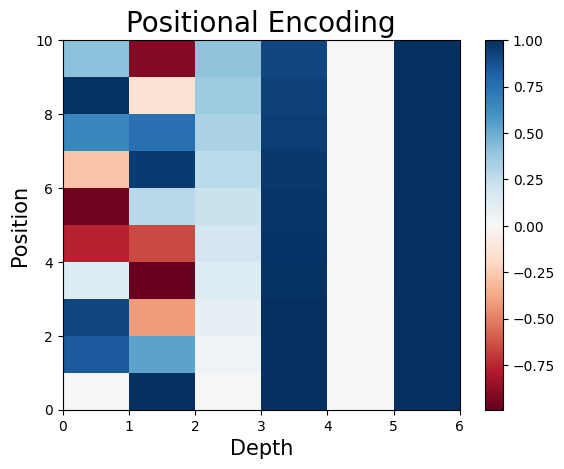

sin and cosine are applied along depth at alternate positions


In [14]:
plt.title('Positional Encoding')
plt.pcolormesh(pos_enc[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d))
plt.ylabel('Position')
plt.colorbar()
plt.show()
print('sin and cosine are applied along depth at alternate positions')

**WHY IT TAKES CARE OF THE LIMITATION IN THE PREVIOUS ENCODINGS**

Each row in the above plot is a positional encoding

Using $\text{sin}$ and $\text{cos}$ in the positional encoding helps the model to attend by relative position. This is because $PE(p+k)$ is a linear transformation of $PE(p)$

Let $10000^{\frac{1}{d}}$ be n

$$PE(p, 2i) = sin(\frac{p}{n^{2i}})$$

$$PE(p, 2i+1) = cos(\frac{p}{n^{2i}})$$

$$PE(p+k, 2i) = sin(\frac{p+k}{n^{2i}})=sin(\frac{p}{n^{2i}})cos(\frac{k}{n^{2i}})+sin(\frac{k}{n^{2i}})cos(\frac{p}{n^{2i}})$$

$$PE(p+k, 2i+1) = sin(\frac{p+k}{n^{2i}})=cos(\frac{p}{n^{2i}})cos(\frac{k}{n^{2i}})-sin(\frac{p}{n^{2i}})sin(\frac{k}{n^{2i}})$$

$$\begin{bmatrix} PE(p+k, 2i) \\ PE(p+k, 2i+1)\end{bmatrix}=\begin{bmatrix} cos(\frac{k}{n^{2i}}) \quad sin(\frac{k}{n^{2i}}) \\ -sin(\frac{k}{n^{2i}}) \quad cos(\frac{k}{n^{2i}}) \end{bmatrix}\begin{bmatrix} PE(p, 2i) \\ PE(p, 2i+1)\end{bmatrix}$$

$$PE(p) = \begin{bmatrix} PE(p, 0) \\ PE(p, 1) \\ \vdots \\ PE(p, 2i) \\ PE(p, 2i+1) \\ \vdots \\ PE(p, 2n) \\ PE(p, 2n+1)\end{bmatrix}$$

Where, $2n+1=d$

$$PE(p+k) = \begin{bmatrix} M_1 \quad 0 \quad 0 \quad \dots \quad 0 \\ 0 \quad M_2 \quad 0 \quad \dots \quad 0 \\ 0 \quad 0 \quad M_3 \quad \dots \quad 0 \\ \vdots \\ \quad 0 \quad 0 \quad \  \ 0 \quad \dots \quad M_{d//2}\end{bmatrix} PE(p)$$

Where, $M_i = \begin{bmatrix} cos(\frac{k}{n^{2i}}) \quad sin(\frac{k}{n^{2i}}) \\ -sin(\frac{k}{n^{2i}}) \quad cos(\frac{k}{n^{2i}}) \end{bmatrix}$

Thereofore, $PE(p+k)$ is a linear function of $PE(p)$, furthermore, the linear transformation does not depend on $p$

# CLOSING ARGUMENTS

As explained in the previous section, the original transformer architecture (introduced by Vaswani et al.) uses sine and cosine functions for generating the positional encodings, although the above encoding has some nice mathematical properties, it is not entirely necesary to have them for the model to be able to attend by relative positions. This is possible because the attention mechanism works by linearly transforming the input embeddings and then taking dot products with the original ones to calculate attention scores

See [this notebook](https://github.com/kolikaran1992/Neural-Networks/blob/main/Self_Attention.ipynb) for more information